In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
from models import *

ModuleNotFoundError: No module named 'models'

In [157]:
net = DeformedConvModel()
net(x)

tensor([[ 2.8315e-02, -7.5787e-02,  8.4222e-02,  2.3027e-02, -9.1419e-05,
          5.4575e-02,  6.9857e-02, -1.2321e-02,  1.3505e-03,  1.5693e-02]],
       grad_fn=<AddmmBackward>)

In [81]:
net = Model()

In [86]:
x = torch.ones([1, 1, 28, 28])

In [87]:
net(x)

tensor([[ 0.0040,  0.0360,  0.0318,  0.0146, -0.0768, -0.0657, -0.0109,  0.0764,
          0.0347, -0.0549]], grad_fn=<AddmmBackward>)

In [162]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='../../data/', train=True, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])), batch_size=64, shuffle=True, num_workers=4)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='../../data/', train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])), batch_size=64, shuffle=True, num_workers=4)

In [38]:
x = next(iter(train_loader))[0]

In [40]:
x.shape

torch.Size([64, 1, 28, 28])

In [113]:
def train(model, loss_fn, optimizer, train_loader, num_epochs=10, log_freq=300):
    for epoch in range (num_epochs):
        tot_loss = 0
        for i, data in enumerate(train_loader):
            inputs, labels = data
            inputs, labels = inputs.cuda(), labels.cuda()
            
            optimizer.zero_grad()

            pred = model(inputs)
            loss = loss_fn(pred, labels)
            loss.backward()
            
            optimizer.step()

            tot_loss += loss.item()
            
            if i % log_freq == (log_freq - 1):
                print('[%d, %5d] loss: %0.3f'%(epoch + 1, i + 1, tot_loss / 1000))
                tot_loss = 0


In [106]:
def test(model, loss_fn, test_loader):
    num_correct = 0
    avg_loss = 0
    for step, (data, targets) in enumerate(test_loader):
        data = data.cuda()
        targets = targets.cuda()

        with torch.no_grad():
            preds = net(data)

        loss = loss_fn(preds, targets)
        avg_loss += loss.item()

        _, pred_labels = torch.max(preds, dim=1)
        
        num_correct += pred_labels.eq(targets).sum().item()

        # Because used a sum, make sure to divide by the length of total number in dataset
    acc = num_correct/len(test_loader.dataset)
    avg_loss /= len(test_loader)

    return acc, avg_loss

In [160]:
net = Model().cuda()
optimizer = optim.SGD(net.parameters(), lr = 0.001, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()

train(net, loss_fn, optimizer, train_loader)
acc, _ = test(net, loss_fn, test_loader)
print('Accuracy: %s'%(acc*100) + '%')

[1,   300] loss: 0.423
[1,   600] loss: 0.171
[1,   900] loss: 0.098
[2,   300] loss: 0.066
[2,   600] loss: 0.053
[2,   900] loss: 0.046
[3,   300] loss: 0.038
[3,   600] loss: 0.034
[3,   900] loss: 0.031
[4,   300] loss: 0.028
[4,   600] loss: 0.026
[4,   900] loss: 0.025
[5,   300] loss: 0.022
[5,   600] loss: 0.022
[5,   900] loss: 0.020
[6,   300] loss: 0.019
[6,   600] loss: 0.018
[6,   900] loss: 0.018
[7,   300] loss: 0.016
[7,   600] loss: 0.015
[7,   900] loss: 0.016
[8,   300] loss: 0.014
[8,   600] loss: 0.015
[8,   900] loss: 0.013
[9,   300] loss: 0.013
[9,   600] loss: 0.012
[9,   900] loss: 0.012
[10,   300] loss: 0.011
[10,   600] loss: 0.011
[10,   900] loss: 0.012
Accuracy: 98.67%


In [161]:
net = DeformedConvModel().cuda()
optimizer = optim.SGD(net.parameters(), lr = 0.001, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()

train(net, loss_fn, optimizer, train_loader)
acc, _ = test(net, loss_fn, test_loader)
print('Accuracy: %s'%(acc*100) + '%')

[1,   300] loss: 0.252
[1,   600] loss: 0.057
[1,   900] loss: 0.037
[2,   300] loss: 0.027
[2,   600] loss: 0.022
[2,   900] loss: 0.019
[3,   300] loss: 0.015
[3,   600] loss: 0.015
[3,   900] loss: 0.014
[4,   300] loss: 0.010
[4,   600] loss: 0.011
[4,   900] loss: 0.011
[5,   300] loss: 0.008
[5,   600] loss: 0.009
[5,   900] loss: 0.008
[6,   300] loss: 0.007
[6,   600] loss: 0.007
[6,   900] loss: 0.007
[7,   300] loss: 0.005
[7,   600] loss: 0.006
[7,   900] loss: 0.005
[8,   300] loss: 0.004
[8,   600] loss: 0.004
[8,   900] loss: 0.004
[9,   300] loss: 0.004
[9,   600] loss: 0.004
[9,   900] loss: 0.003
[10,   300] loss: 0.003
[10,   600] loss: 0.003
[10,   900] loss: 0.003
Accuracy: 99.2%


In [163]:
rot_train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='../../data/', train=True, transform=transforms.Compose([
        # transforms.Pad(16), # Make larger
        # transforms.RandomAffine(0, translate=(0.4, 0.4)), # Random shift
        transforms.RandomAffine(120),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])), batch_size=64, shuffle=True, num_workers=4)
    
rot_test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='../../data/', train=False, transform=transforms.Compose([
        # transforms.Pad(16), # Make larger
        # transforms.RandomAffine(0, translate=(0.4, 0.4)), # Random shift
        transforms.RandomAffine(120),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])), batch_size=64, shuffle=True, num_workers=4)

In [164]:
net = Model().cuda()
optimizer = optim.SGD(net.parameters(), lr = 0.001, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()

train(net, loss_fn, optimizer, rot_train_loader)
acc, _ = test(net, loss_fn, rot_test_loader)
print('Accuracy: %s'%(acc*100) + '%')

[1,   300] loss: 0.582
[1,   600] loss: 0.471
[1,   900] loss: 0.382
[2,   300] loss: 0.301
[2,   600] loss: 0.248
[2,   900] loss: 0.208
[3,   300] loss: 0.177
[3,   600] loss: 0.156
[3,   900] loss: 0.141
[4,   300] loss: 0.129
[4,   600] loss: 0.119
[4,   900] loss: 0.112
[5,   300] loss: 0.107
[5,   600] loss: 0.102
[5,   900] loss: 0.096
[6,   300] loss: 0.092
[6,   600] loss: 0.088
[6,   900] loss: 0.089
[7,   300] loss: 0.083
[7,   600] loss: 0.082
[7,   900] loss: 0.078
[8,   300] loss: 0.077
[8,   600] loss: 0.073
[8,   900] loss: 0.074
[9,   300] loss: 0.071
[9,   600] loss: 0.068
[9,   900] loss: 0.070
[10,   300] loss: 0.068
[10,   600] loss: 0.067
[10,   900] loss: 0.067
Accuracy: 94.3%


In [165]:
net = DeformedConvModel().cuda()
optimizer = optim.SGD(net.parameters(), lr = 0.001, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()

train(net, loss_fn, optimizer, rot_train_loader)
acc, _ = test(net, loss_fn, rot_test_loader)
print('Accuracy: %s'%(acc*100) + '%')

[1,   300] loss: 0.490
[1,   600] loss: 0.242
[1,   900] loss: 0.151
[2,   300] loss: 0.108
[2,   600] loss: 0.087
[2,   900] loss: 0.079
[3,   300] loss: 0.068
[3,   600] loss: 0.066
[3,   900] loss: 0.060
[4,   300] loss: 0.059
[4,   600] loss: 0.055
[4,   900] loss: 0.052
[5,   300] loss: 0.050
[5,   600] loss: 0.049
[5,   900] loss: 0.046
[6,   300] loss: 0.047
[6,   600] loss: 0.048
[6,   900] loss: 0.044
[7,   300] loss: 0.043
[7,   600] loss: 0.044
[7,   900] loss: 0.042
[8,   300] loss: 0.039
[8,   600] loss: 0.042
[8,   900] loss: 0.040
[9,   300] loss: 0.039
[9,   600] loss: 0.039
[9,   900] loss: 0.036
[10,   300] loss: 0.037
[10,   600] loss: 0.036
[10,   900] loss: 0.038
Accuracy: 96.34%


In [177]:
x,y = next(iter(rot_test_loader))

In [171]:
x.shape

torch.Size([64, 1, 28, 28])

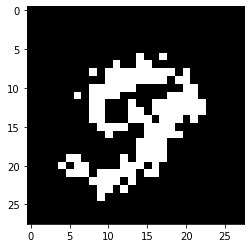

In [210]:
single_pil = transforms.ToPILImage()(x[0,:,:,:])
# clip image, for visualization purposes
thresh = lambda x : 255 if x > 148 else 0
single_pil = single_pil.convert('L').point(thresh, mode='1')
single_pil = single_pil.convert('RGB')
plt.imshow(single_pil)

In [181]:
y

tensor([9, 3, 8, 8, 6, 5, 3, 1, 7, 1, 1, 4, 6, 6, 9, 4, 4, 7, 1, 6, 7, 4, 2, 6,
        4, 3, 1, 1, 2, 1, 4, 1, 9, 3, 4, 2, 5, 9, 0, 2, 5, 3, 0, 0, 4, 2, 8, 2,
        1, 6, 6, 0, 0, 9, 5, 5, 5, 3, 7, 3, 8, 2, 9, 3])

In [205]:
torch.argmax(net(x.cuda()), axis=1)

tensor([9, 3, 8, 8, 6, 5, 3, 1, 7, 1, 1, 4, 6, 6, 9, 4, 4, 7, 1, 6, 7, 4, 2, 9,
        4, 3, 1, 1, 2, 1, 4, 1, 9, 3, 4, 2, 5, 9, 0, 2, 5, 3, 0, 0, 4, 2, 8, 2,
        1, 6, 6, 0, 0, 9, 5, 5, 5, 3, 7, 3, 8, 2, 9, 3], device='cuda:0')

In [214]:
sample = x[0, :, : ,:].reshape(1, 1, 28, 28).cuda()

In [255]:
isinstance(net.features[3], DeformConv)

True

In [258]:
with torch.no_grad():
    output = sample
    for i, layer in enumerate(net.features):
        if isinstance(layer, DeformConv):
            output = layer.offset_net(output)
            break
        output = layer(output)

In [259]:
output = output.cpu()

In [261]:
sample.shape

torch.Size([1, 1, 28, 28])

In [260]:
output.shape

torch.Size([1, 18, 13, 13])

In [264]:
output[0, :, 0, 0]

tensor([-0.2032, -0.0283,  0.0596, -0.0539, -0.3373, -0.4468, -0.2435, -0.2105,
         0.1778, -0.3781, -0.1805, -0.0886,  0.0448,  0.0258, -0.4595, -0.0653,
         0.9735,  0.1929])

In [265]:
offset_map = output[0, :, : , :]

Trying to reference raw implementation here: https://github.com/pytorch/vision/pull/1586/files

In [ ]:
out_x = 
out_y = out_x
wight_w = 3
weight_h = 3


for i in range (13):
    for j in range(13):
        offset_idx = 2 * (i * 13 + j)
        print('x: %s, y: %s')%(output_map[offset_idx * (13 * 13) + 13 * 13 + 13], output_map[]